In [1]:
import praw
import pandas as pd
from praw.models import MoreComments
import requests
from datetime import datetime, timedelta
import numpy as np

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import re

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('vader_lexicon')
# nltk.download('omw-1.4')

In [2]:
posts = pd.read_csv('reddit posts.csv')
posts.head()

,Title,Post Text,ID,Score,Date
0,How are we expecting the Quarterly results to ...,Christmas? Supply problems? Inflation? I know ...,zyhhfv,2,2022-12-30 05:46:14
1,$AAPL could fall below $100 - analyst,NaN,zy4bzk,0,2022-12-29 20:33:01
2,Apple’s Plans for Car and AR Headset Reflect M...,NaN,zj14du,0,2022-12-12 01:40:54
3,AAPL Stock: Sellers Drive The Price Lower But ...,NaN,zeypyv,2,2022-12-07 19:21:29
4,"For anyone holding AAPL, be sure to come THROU...","We are all here for AAPL longterm, please be s...",zdqf7p,0,2022-12-06 09:04:56


In [3]:
comments = pd.read_csv('reddit comments.csv')
comments.head()

,Comment,Post ID
0,The market is not rational when it comes to th...,zyhhfv
1,Just got back from purchasing an Apple Watch s...,zyhhfv
2,I believe it will be a bloodbath \n\nLong term...,zyhhfv
3,When are they due ?,zyhhfv
4,I'm an analyst and I say it can go above $500 ...,zy4bzk


### Clean Data + Sentiment Analysis

In [4]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = text.lower() # Convert to lowercase
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    return ' '.join(filtered_words)

In [5]:
posts['Post Text'] = posts['Post Text'].fillna("")

# Convert date from string to date object
posts['Date'] = posts['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [6]:
# Clean the text
posts['Cleaned Title'] = posts['Title'].apply(lambda x: clean_text(x))
posts['Cleaned Text'] = posts['Post Text'].apply(lambda x: clean_text(x))
comments['Cleaned Comment'] = comments['Comment'].apply(lambda x: clean_text(x))

In [7]:
# Calculate sentiment score for each of the cleaned text
sia = SentimentIntensityAnalyzer()
posts['Title Score'] = posts['Cleaned Title'].apply(lambda x: sia.polarity_scores(x)['compound'])
posts['Text Score'] = posts['Cleaned Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
comments['Comment Score'] = comments['Cleaned Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [8]:
posts.head()

,Title,Post Text,ID,Score,Date,Cleaned Title,Cleaned Text,Title Score,Text Score
0,How are we expecting the Quarterly results to ...,Christmas? Supply problems? Inflation? I know ...,zyhhfv,2,2022-12-30 05:46:14,expecting quarterly results look,christmas supply problems inflation know apple...,0.0000,0.0258
1,$AAPL could fall below $100 - analyst,,zy4bzk,0,2022-12-29 20:33:01,aapl could fall analyst,,0.0000,0.0000
2,Apple’s Plans for Car and AR Headset Reflect M...,,zj14du,0,2022-12-12 01:40:54,apples plans car ar headset reflect pragmatic era,,0.0000,0.0000
3,AAPL Stock: Sellers Drive The Price Lower But ...,,zeypyv,2,2022-12-07 19:21:29,aapl stock sellers drive price lower longer te...,,-0.2960,0.0000
4,"For anyone holding AAPL, be sure to come THROU...","We are all here for AAPL longterm, please be s...",zdqf7p,0,2022-12-06 09:04:56,anyone holding aapl sure come open discussions,aapl longterm please sure come open discussions,0.3182,0.5574


In [9]:
comments.head()

,Comment,Post ID,Cleaned Comment,Comment Score
0,The market is not rational when it comes to th...,zyhhfv,market rational comes cupertino crew add recen...,0.4215
1,Just got back from purchasing an Apple Watch s...,zyhhfv,got back purchasing apple watch series union s...,0.6249
2,I believe it will be a bloodbath \n\nLong term...,zyhhfv,believe bloodbath long term year dont expect m...,-0.6808
3,When are they due ?,zyhhfv,due,0.0000
4,I'm an analyst and I say it can go above $500 ...,zy4bzk,im analyst say go saying something could happe...,0.8317


In [10]:
# Get the list of comments for each post
comments_score = comments.groupby('Post ID').agg(list).reset_index()
comments_score = comments_score.drop(columns=['Comment', 'Cleaned Comment'])
comments_score.head()

,Post ID,Comment Score
0,cmqtw6,[0.0]
1,fum21r,"[0.0, 0.8126, 0.4404, -0.5267]"
2,ktdt21,[0.3612]
3,l6j1ie,"[0.6705, 0.3182, 0.0, -0.128, 0.0, -0.3818]"
4,l6llcx,[0.0]


In [11]:
# Merge comments with their respective post
data = pd.merge(posts, comments_score, left_on='ID', right_on='Post ID', how='left')

# Get the average score of post and post comments
def apply_condition(row):
    if np.isnan(np.sum(row['Comment Score'])):
        return (row['Title Score'] + row['Text Score']) / 2
    else:
        return (row['Title Score'] + row['Text Score'] + sum(row['Comment Score'])) / (len(row['Comment Score']) + 2)

data['Sentiment Score'] = data.apply(apply_condition, axis=1)

# Drop columns that are not needed
drop_columns = ['Title', 'Post Text', 'Cleaned Title', 'Cleaned Text', 'Title Score', 'Text Score', 'Post ID', 'Comment Score']
data = data.drop(columns=drop_columns)

data

,ID,Score,Date,Sentiment Score
0,zyhhfv,2,2022-12-30 05:46:14,0.065233
1,zy4bzk,0,2022-12-29 20:33:01,0.138617
2,zj14du,0,2022-12-12 01:40:54,0.289633
3,zeypyv,2,2022-12-07 19:21:29,0.065780
4,zdqf7p,0,2022-12-06 09:04:56,0.437800
...,...,...,...,...
570,ktdt21,6,2021-01-09 06:45:35,0.416567
571,fum21r,2,2020-04-04 10:51:09,0.267850
572,eoo3tk,3,2020-01-15 01:09:56,0.292950
573,d43lcy,1,2019-09-14 18:38:50,0.000000


In [12]:
# Convert to weekly average scores
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2022-12-31')

days_to_subtract = (7 + start_date.weekday()) % 7
start_date -= timedelta(days=days_to_subtract)

weeks = pd.date_range(start=start_date, end=end_date, freq='W-TUE')

scores = []

for week in weeks:
    start_week = week
    end_week = week + pd.Timedelta(days=6)
    week_scores = data[data['Date'].between(start_week, end_week, inclusive='both')][['Score', 'Sentiment Score']]
    week_scores['Score'] = week_scores['Score'] + 1 # Smoothing
    if len(week_scores) > 0:
        scores.append({
            'Week Start': start_week, 
            'Week End': end_week, 
            'Sentiment Score': week_scores['Sentiment Score'].mean(),
            'Weighted Sentiment Score': (week_scores['Score'] * week_scores['Sentiment Score']).sum() / week_scores['Score'].sum()
        })
        
weekly_scores = pd.DataFrame(scores)
weekly_scores

,Week Start,Week End,Sentiment Score,Weighted Sentiment Score
0,2019-08-06,2019-08-12,0.113333,0.113333
1,2019-09-10,2019-09-16,0.000000,0.000000
2,2020-01-14,2020-01-20,0.292950,0.292950
3,2020-03-31,2020-04-06,0.267850,0.267850
4,2021-01-05,2021-01-11,0.416567,0.416567
...,...,...,...,...
88,2022-10-18,2022-10-24,0.337939,0.313955
89,2022-10-25,2022-10-31,0.091461,0.090577
90,2022-11-29,2022-12-05,0.141120,0.152096
91,2022-12-06,2022-12-12,0.251790,0.158785


In [13]:
# Positive sentiment : (compound score >= 0.05) 
# Neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
# Negative sentiment : (compound score <= -0.05)
def sentiment(score):
    if (score >= 0.05):
        return 'positive'
    elif (score <= -0.05):
        return 'negative'
    else:
        return 'neutral'
    
weekly_scores['Weighted Sentiment'] = weekly_scores['Weighted Sentiment Score'].apply(sentiment)
weekly_scores

,Week Start,Week End,Sentiment Score,Weighted Sentiment Score,Weighted Sentiment
0,2019-08-06,2019-08-12,0.113333,0.113333,positive
1,2019-09-10,2019-09-16,0.000000,0.000000,neutral
2,2020-01-14,2020-01-20,0.292950,0.292950,positive
3,2020-03-31,2020-04-06,0.267850,0.267850,positive
4,2021-01-05,2021-01-11,0.416567,0.416567,positive
...,...,...,...,...,...
88,2022-10-18,2022-10-24,0.337939,0.313955,positive
89,2022-10-25,2022-10-31,0.091461,0.090577,positive
90,2022-11-29,2022-12-05,0.141120,0.152096,positive
91,2022-12-06,2022-12-12,0.251790,0.158785,positive


In [14]:
weekly_scores['Weighted Sentiment'].value_counts()

positive    81
neutral     11
negative     1
Name: Weighted Sentiment, dtype: int64

In [15]:
# weekly_scores.to_csv('reddit sentiment scores.csv', index = False)

### EDA

In [16]:
import matplotlib.pyplot as plt

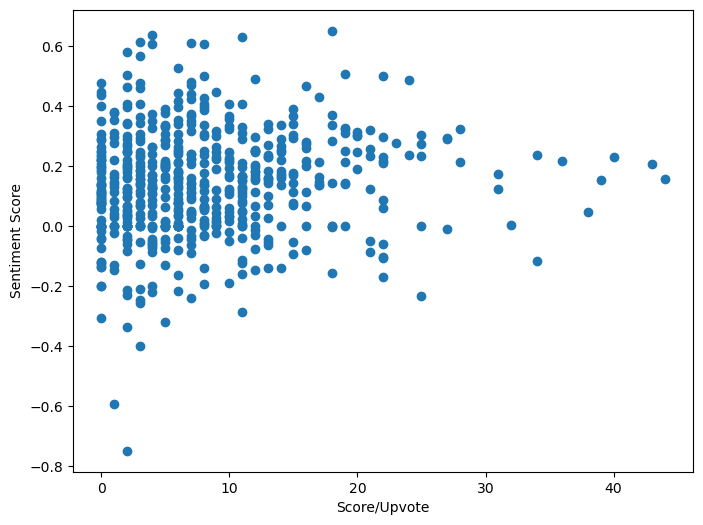

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(data['Score'], data['Sentiment Score'])
plt.xlabel('Score/Upvote')
plt.ylabel('Sentiment Score')
plt.show()

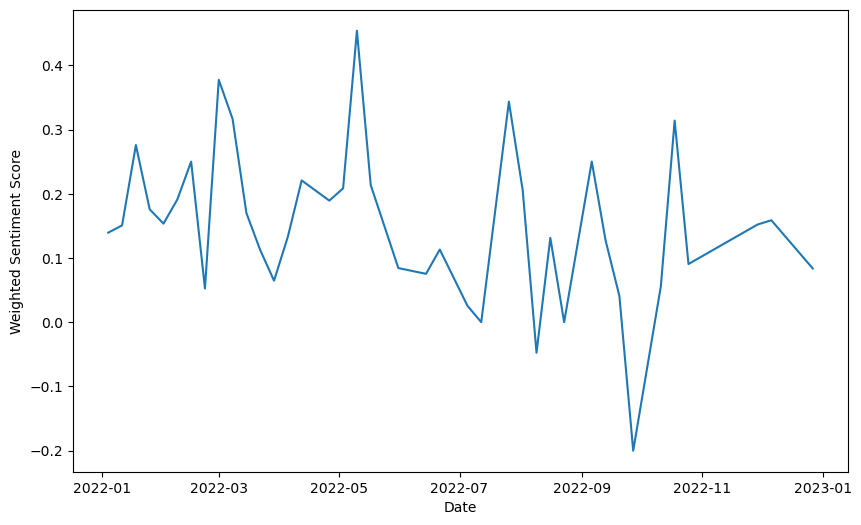

In [18]:
weekly_data_2022 = weekly_scores[weekly_scores['Week Start'].dt.year == 2022]

fig = plt.figure(figsize=(10, 6))
plt.plot(weekly_data_2022['Week Start'], weekly_data_2022['Weighted Sentiment Score'])
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment Score')
plt.show()

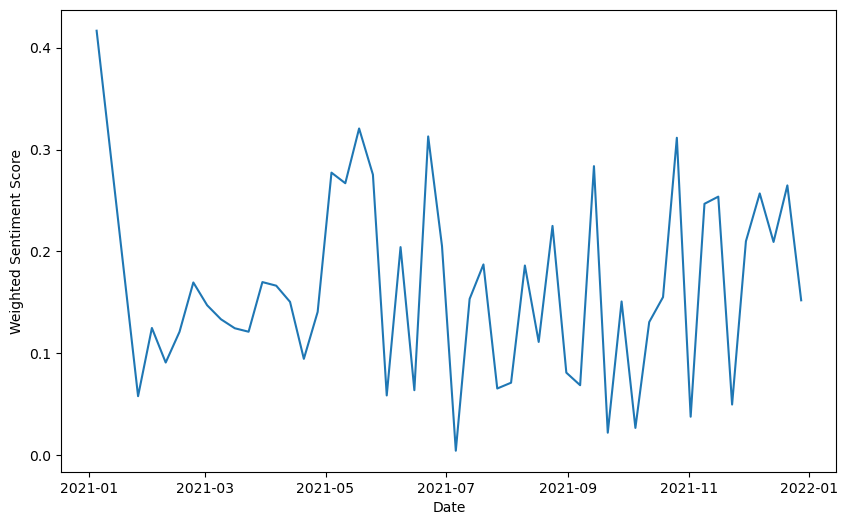

In [19]:
weekly_data_2021 = weekly_scores[weekly_scores['Week Start'].dt.year == 2021]

fig = plt.figure(figsize=(10, 6))
plt.plot(weekly_data_2021['Week Start'], weekly_data_2021['Weighted Sentiment Score'])
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment Score')
plt.show()